In [5]:
data_root = "../../data/"
#stats stuff
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing

# ML stuff
import numpy as np
from numpy.fft import *
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
import pandas as pd
import lightgbm as lgb


# DL stuff
from torch.autograd import Variable
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)



# basic stuff
import datetime
import io
import os
from os.path import join
import re
from collections import Counter
from tqdm import tqdm



In [3]:
########################################################################
################## this cell is dedicated to kaggle ####################
########################################################################

# set index as datetime
def date_index_nasdaq(nasdaq):
    nasdaq_c = nasdaq.copy()
    dates = pd.to_datetime(nasdaq_c.Date)
    nasdaq_c.set_index(dates, inplace=True)
    # set date as index
    nasdaq_c.drop("Date", axis=1, inplace=True)
    # ここでFBとかTESLAとかに合わせている
    nasdaq_c = nasdaq_c["2012-05-18":]
    return nasdaq_c

############## REINDEX FUNCTION AND PREPARE_STOCK FUNCTION ARE PRETTY MUCH SAME, HOWEVER, I PREFER THE PRIOR ##################
# for ARIMA or some shit    
def reindex(df):
    return df.reindex(pd.date_range(df.index[0], df.index[-1])).fillna(method="ffill")

# for prepare_stock
def date_range_df(start, end, column_name = "Time"):
    date_range = pd.date_range(start, end)
    df = pd.DataFrame(date_range, columns = [column_name])
    df.set_index(column_name, inplace=True)
    return df

# merging with date range df
def prepare_stock(nasdaq, start, end, stock_name="AAPL", drop=True):
    nasdaq = nasdaq.loc[nasdaq["Name"]==stock_name]
    dates = date_range_df(start, end)
    new_nasdaq = dates.merge(nasdaq, how="left", left_index=True, right_index=True)
    if drop:
        new_nasdaq.dropna(inplace=True)
    return new_nasdaq
#############################################################################################################################

# create features volatility, volume, adj close
# def get_features(nasdaq, features):
#     #rename Adj Close
#     nasdaq.rename(columns={"Adj Close":"Adj_Close"}, inplace=True)
#     nasdaq["log_Volatility"] = np.log(nasdaq.High - nasdaq.Low + 1)
#     nasdaq["log_Volume"] = np.log(nasdaq.Volume + 1) 
#     nasdaq["log_Adj_Close"] = np.log(nasdaq["Adj_Close"] + 1)
#     # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()
    
#     nasdaq.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
#     # nasdaq.dropna(inplace = True)
#     return nasdaq

def get_features(df, features):
    #rename Adj Close
    
    df.rename(columns={"Adj Close":"Adj_Close"}, inplace=True) 
    df["log_Volatility"] = np.log(df.High - df.Low + 1)
    df["log_Volume"] = np.log(df.Volume + 1) 
    df["log_Adj_Close"] = np.log(df["Adj_Close"] + 1)
    # df["day_of_week"] = np.array(list(map(lambda date: date.weekday(), df.index)))

    if 'Adj_Close' not in features:
        df.drop(columns=["Adj_Close"], inplace=True)
    # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()

    df.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
    # nasdaq = nasdaq[features]

    # nasdaq.dropna(inplace = True)
    return df

# this will return feature engineered stock dataframe
def get_stock(nasdaq, features, stock_name="AAPL"):
    nasdaq_c = date_index_nasdaq(nasdaq)
    stock = prepare_stock(nasdaq_c, nasdaq_c.index[0], nasdaq_c.index[-1], stock_name)
    stock = get_features(stock, features)
    stock.fillna("ffill", inplace=True)
    return stock

# plot heatmap for top stocks
def plot_attribute(nasdaq, using,feature="log_Adj_Close"):
    stocks = pd.DataFrame()
    for name in using:
        stocks[name] = get_stock(nasdaq, name)[feature]
    stocks.dropna(inplace=True)
    stocks.plot()
    plt.show()

####### In the 2 functions below, we are adding weekday and making dataframe/nparray to feed into LSTM however ###########
####### prob we could have done this in like get_stock or something #######
# the main difference between the two is , the prior is just adding weekday at the end,
# whereas the latter function is adding it to every stock
def get_train_df(nasdaq, using, features):
    df_features_arr = reindex(get_stock(nasdaq, using[0])).to_numpy().T
    for name in using[1:]:
        adding = reindex(get_stock(nasdaq, name)).to_numpy().T
        df_features_arr = np.concatenate([df_features_arr, adding])
    df_features_arr = df_features_arr.T

    ## df_features = pd.DataFrame(data=df_features_arr, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))
    
    # making columns
    # features must not include weekday here
    if "weekday" in features:
        features.remove("weekday")
    col_one = []
    for element in using:
        for i in range(len(features)):
            col_one.append(element)
    col_two = list(features)*len(using)
    # print(len(col_one), len(col_two))

    # scaling 
    scaler = MinMaxScaler((-1, 1))
    scaled = scaler.fit_transform(df_features_arr)
    df_features = pd.DataFrame(data=scaled, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))

    df_features.index = pd.date_range("2012-05-18", "2021-09-10")

    day_of_week = np.array(list(map(lambda date: date.weekday(), df_features.index)))
    day_of_week = day_of_week.reshape(-1, 1)
    day_of_week = pd.Series(data=scaler.fit_transform(day_of_week).reshape(-1,), index = df_features.index)
    df_features["weekday"] = day_of_week
    if "weekday" not in features:
        features.append("weekday")

    return df_features, features


# for feeding into network
# this doesn't work because of too many dimensions
def get_train_arr(nasdaq, using, features):
    df_features_arr = []
    for name in using:
        arr = reindex(get_stock(nasdaq, name)).to_numpy()
        # scaling for each column, for each stock_df in nasdaq
        scaler = MinMaxScaler(feature_range=(-1, 1))
        arr_scaled = scaler.fit_transform(arr)    

        # adding day of week
        day_of_week = np.array(list(map(lambda date: date.weekday(), pd.date_range("2012-05-18", "2021-09-10"))))
        day_of_week = day_of_week.reshape(-1, 1)
        day_of_week = scaler.fit_transform(day_of_week)
      
        arr_scaled = np.concatenate([arr_scaled, day_of_week], axis=1)

        df_features_arr.append(arr_scaled)


    df_features_arr = np.array(df_features_arr)
    if "weekday" not in features:
        features.append("weekday")
    df_features_arr = df_features_arr.reshape(-1, len(features), 7)

    return df_features_arr, features


def sliding_windows_mutli_features(data, seq_length, target_cols_ids):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = data[i:(i+seq_length), :] 
        _y = data[i+seq_length, target_cols_ids] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

def get_Xy(df, window_size):
    log_adj_close_cols_ids = []
    volatility_cols_ids = []
    volume_cols_ids = []
    weekday_col_id = []
    count = 0
    for col in df.columns:
        # print(col)
        if col[1] == "Adj_Close":
            df.drop(col, axis=1, inplace=True)
            count -= 1
        if col[1] == "log_Adj_Close":
            log_adj_close_cols_ids.append(count)
        if col[1] == "log_Volume":
            volume_cols_ids.append(count)
        if col[1] == "log_Volatility":
            volatility_cols_ids.append(count)
        if col[0] == "weekday":
            weekday_col_id.append(count)
        count += 1
    df = df.to_numpy()
    x, y = sliding_windows_mutli_features(df, window_size, log_adj_close_cols_ids)

    # x.shape, y.shape
    return x, y

def get_train_test(x, y, train_ratio):
    train_size = int(len(y)*train_ratio)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    return trainX, trainY, testX, testY


def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

def random_search_lgbm(X, y, params_space):
    params_log = {}
    iteration = 40
    cv = TimeSeriesSplit()
    for i in tqdm(range(iteration)):
        params = {}
        for key in params_space.keys():
            param_list = params_space[key]
            length = len(param_list)
            idx =np.random.randint(0,length) 
            params.update({key:param_list[idx]})
            # fit model to data
        
        model = lgb.LGBMRegressor(**params)
        for train_idx, test_idx, in cv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test).squeeze()
            coef_score = np.corrcoef(y_pred, y_test)[0][1]
            rmse_score = np.sqrt(mean_squared_error(y_pred, y_test))
        params_log.update({i:[coef_score, rmse_score, params]})

    sorted_by_coef=sorted(params_log.items(), key = lambda item: item[1][0], reverse=True)
    sorted_by_rmse=sorted(params_log.items(), key = lambda item: item[1][1])
    
    return sorted_by_coef, sorted_by_rmse


def binary_y(y_np, criterion):
    for i in range(len(y_np)):
        if y_np[i] > criterion:
            y_np[i] = int(1)
        else:
            y_np[i] = int(0)
        
    return y_np


def sliding_windows_single_feature(X, y, seq_length):
    x = []
    Y = []

    for i in range((X.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = X[i:(i+seq_length), :] 
        _y = y[i+seq_length] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        Y.append(_y)

    return np.array(x), np.array(Y)

def get_bc_per_stock_Xy(nasdaq, features, stock_name, window_size, train_ratio, val_ratio):
    stock = get_stock(nasdaq, features, stock_name)

    stock_new = stock.copy()
    stock_log_adj = stock["log_Adj_Close"]
    stock_log_adj_diff = stock_log_adj.shift(-1) - stock_log_adj
    stock_new["log_Adj_Close"] = stock_log_adj_diff # tomorrow - today
    X = stock_new
    y = stock_new["log_Adj_Close"].iloc[1:-1] #　そのまま, getting rid of nan although ind 0 is not nan for y
    X["log_Adj_Close"] = stock_new["log_Adj_Close"].shift(1) # today - yesterday
    X = X.iloc[1:-1] # getting rid of nans
    # new_index = y.index


    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y.to_numpy().reshape(-1,1))

    # to 1 and 0 two class classification



    # X[:, 2] = binary_y(X[:, 2], c) ######CHANGED FOR GBT_3##########
    y = binary_y(y, c)

    X, y = sliding_windows_single_feature(X, y, window_size)

    print("len >> ",len(X))

    train_size = int(X.shape[0]*train_ratio)
    val_size = int(X.shape[0]*val_ratio)
    X_train, X_val, X_test = X[:train_size, :, :], X[train_size:train_size + val_size, :, :], X[train_size + val_size:, :, :]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    
    return X_train, X_test, X_val, y_val, y_train, y_test

In [4]:
#################### LOAD DATA ######################
################ DEFINE CONSTANTS ###################
##### we will only predict for one stock here #######

nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")

c = 0.14 # this is for scaled apple stock so that the two classes have roughly the same amount of data points
window_size = 50
# train_ratio = 0.8316
train_ratio = 0.75 
val_ratio = 0.15

stock_name = "AAPL"
DROPOUT = 0.2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# the order of the features is extremely important for latter indexing so make sure
features = ['log_Volatility', 'log_Volume', 'log_Adj_Close']


# X_train, X_test, X_val, y_val, y_train, y_test = get_bc_per_stock_Xy(nasdaq, features, stock_name, window_size, train_ratio, val_ratio)

- below are just some commented out lines

In [4]:
######################## ADDING DIALATED TARGET VALUES FOR X ########################
######################## THIS PEEKS INTO THE FUTURE(I THINK) ########################


# stock = get_stock(nasdaq, features, stock_name=stock_name)
# stock_new = stock.copy()
# stock_log_adj = stock["log_Adj_Close"]
# stock_log_adj_diff = stock_log_adj.shift(-1) - stock_log_adj
# stock_new["log_Adj_Close"] = stock_log_adj_diff # tomorrow - today
# X = stock_new
# y = stock_new["log_Adj_Close"].iloc[1:-1] #　そのまま, getting rid of nan although ind 0 is not nan for y
# X["log_Adj_Close"] = stock_new["log_Adj_Close"].shift(1) # today - yesterday
# X = X.iloc[1:-1] # getting rid of nans 
# assert len(X) == len(y)
# orig_size = len(X)

# window_size_ = window_size - 1
# for i in range(1, window_size_ + 1):
#     X[f"log_Adj_Close_{i}dil"] = X["log_Adj_Close"].shift(i)


# X = X.dropna()
# new_size = len(X)

# y = y[orig_size-new_size:] # compensating for dropna after adding dialated past target values



# scaler = MinMaxScaler(feature_range=(-1, 1))
# X = scaler.fit_transform(X)
# y = scaler.fit_transform(y.to_numpy().reshape(-1, 1))

# y = binary_y(y, c)

# train_size = int(X.shape[0]*train_ratio)
# val_size = int(X.shape[0]*val_ratio)

# # print(train_size + val_size)
# X_train, X_val, X_test = X[:train_size, :], X[train_size:train_size + val_size, :], X[train_size + val_size:, :]
# y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
# assert (len(y_train) + len(y_test) + len(y_val)) == new_size

# print(new_size)

In [73]:
# adding week, month and year for letting model search through time
stock = get_stock(nasdaq, features, stock_name=stock_name)
stock_new = stock.copy()
stock_log_adj = stock["log_Adj_Close"]
stock_log_adj_diff = stock_log_adj.shift(-1) - stock_log_adj
stock_new["log_Adj_Close"] = stock_log_adj_diff # tomorrow - today

X = stock_new.copy()


y = X["log_Adj_Close"].shift(-1)[:-2] # smoothing y here for alignment issues
X = X.iloc[:-2]

# X = X.ewm(alpha=0.7).mean()# exp smoothing for all 

############################################
############################################
# trying exponential smoothing for X and y #
############################################
############################################

# y=y.iloc[1:-1] #　そのまま, getting rid of nan although ind 0 is not nan for y
# # plt.show()
# smooth_feature = "log_Adj_Close"
# plt.plot(stock_new[smooth_feature])
# plt.plot(y)
# plt.plot(X[smooth_feature].shift(1))
# plt.legend(["y", "s"])
# plt.xlim((pd.to_datetime('2012-05-18'), pd.to_datetime('2012-07-01')))



In [74]:


# X["log_Adj_Close"] = stock_new["log_Adj_Close"].shift(-1) #これを1にしていたため、xとyがalignされてしまっていた# today - yesterday

# X = X.iloc[:-3] # getting rid of nans 
# y = y.iloc[:-1]



[]

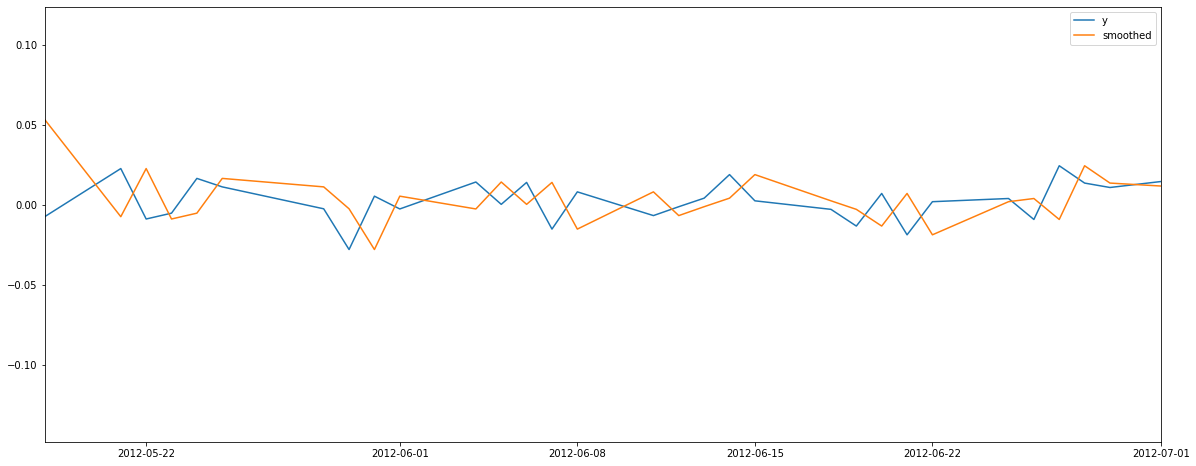

In [75]:
plt.plot(y, label="y")
plt.plot(X["log_Adj_Close"], label="smoothed")
plt.legend()
plt.xlim((pd.to_datetime('2012-05-18'), pd.to_datetime('2012-07-01')))
plt.plot()

In [71]:

day_of_week = np.array(list(map(lambda date: date.day_of_week, X.index)))
day_of_month = np.array(list(map(lambda date: date.days_in_month, X.index)))
day_of_year = np.array(list(map(lambda date: date.day_of_year, X.index)))

X["day_of_week"] = day_of_week
X["day_of_month"] = day_of_month
X["day_of_year"] = day_of_year


scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.to_numpy().reshape(-1, 1))

# for binary classification!!
c = 0.14
y = binary_y(y, c)

#################### FOR SVC !!!!!!! ########################
svc = False
if svc:
    scaler_ = StandardScaler()
    X = scaler_.fit_transform(X)
    y = scaler.fit_transform(y)


train_size = int(X.shape[0]*train_ratio)
val_size = int(X.shape[0]*val_ratio)

# print(train_size + val_size)
X_train, X_val, X_test = X[:train_size, :], X[train_size : train_size + val_size, :], X[train_size + val_size:, :]
y_train, y_val, y_test = y[:train_size], y[train_size : train_size + val_size], y[train_size + val_size:]

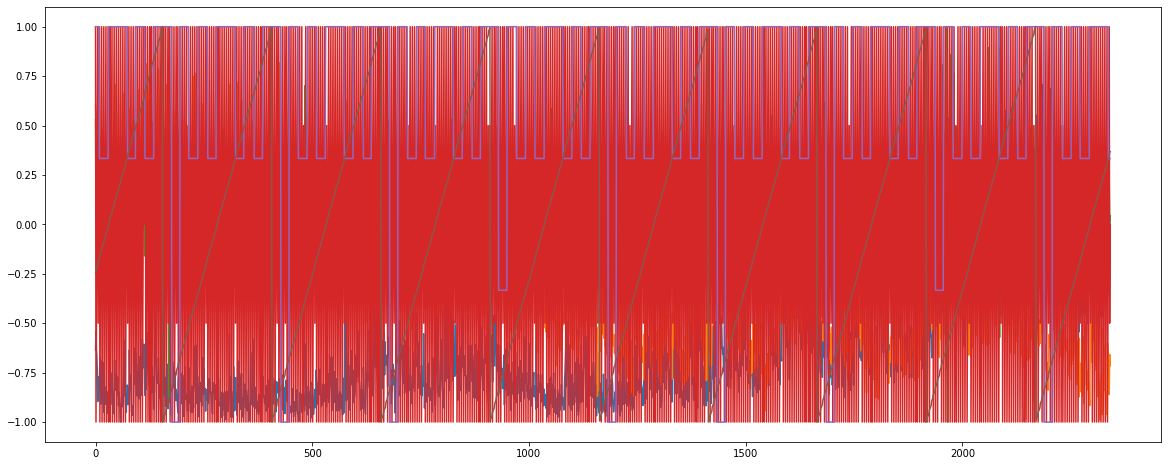

In [72]:
plt.plot(X)
# plt.savefig("standart_scaled.png")

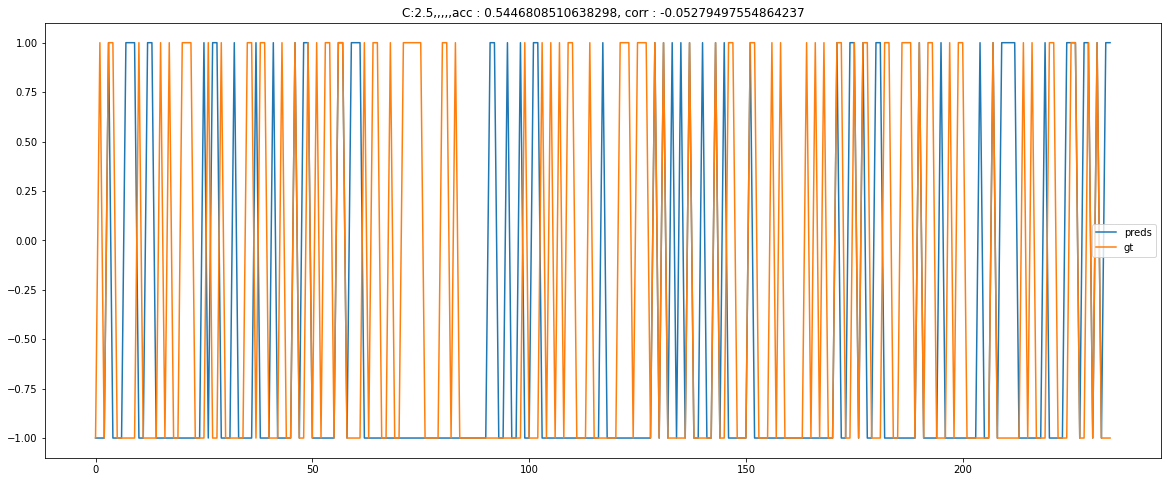

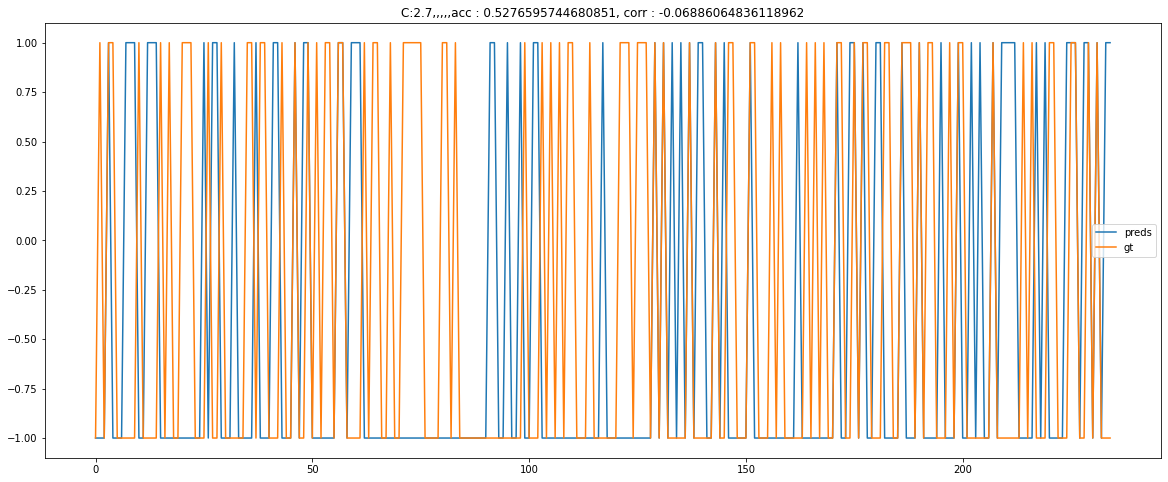

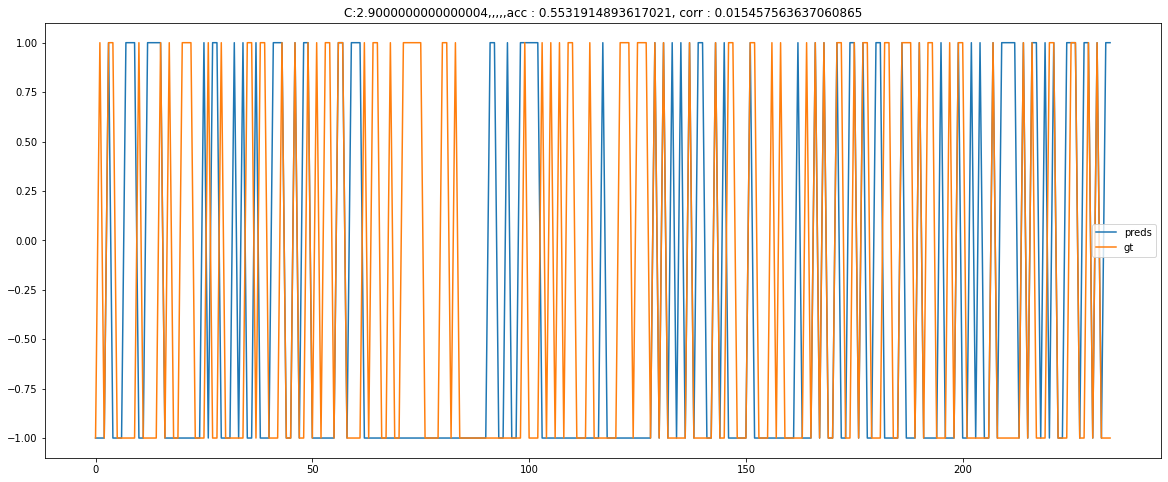

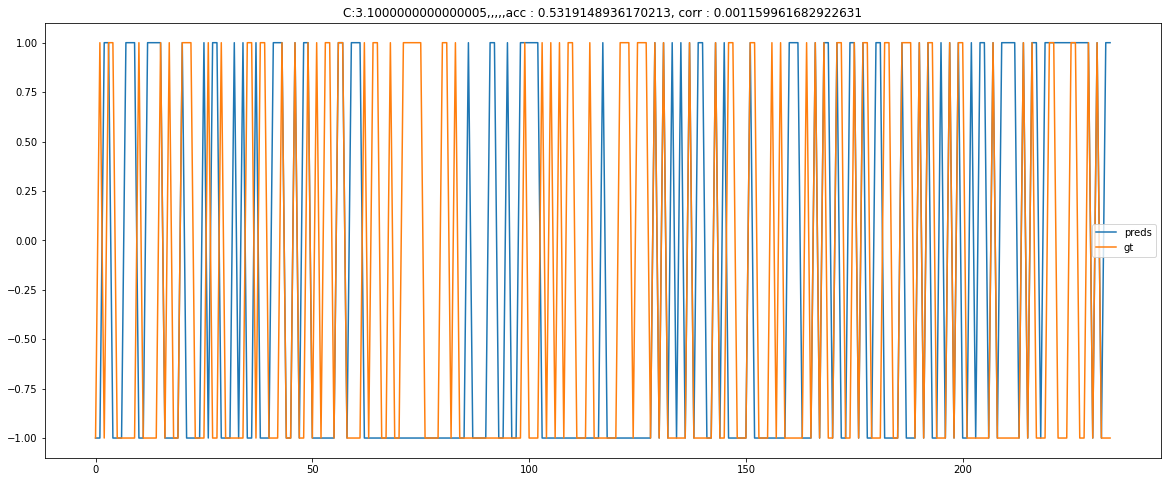

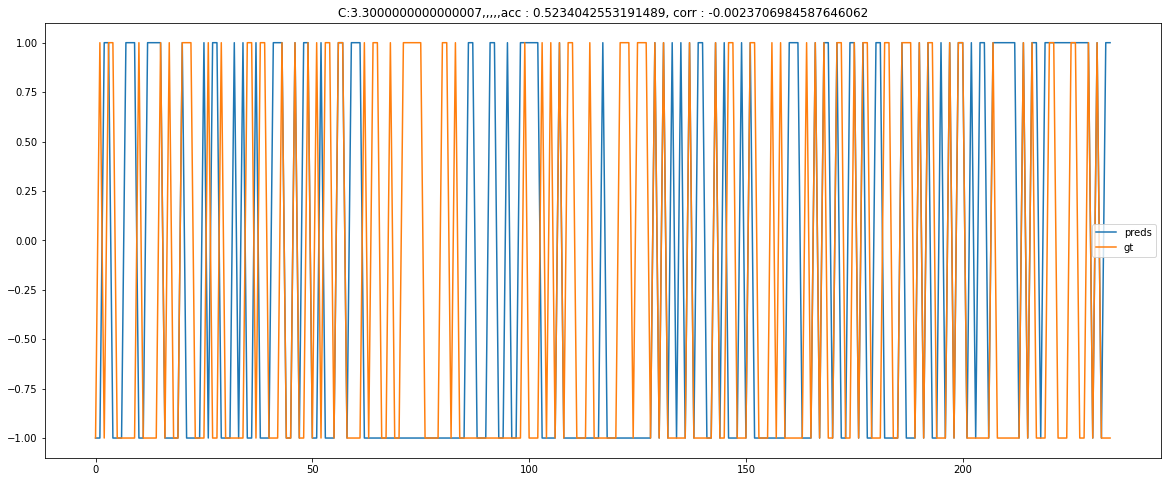

In [8]:
y_test = y_test.squeeze()
for i in np.arange(2.5, 3.5, 0.2):
    clf = SVC(C=i)
    clf.fit(X_train, y_train.squeeze())
    preds = clf.predict(X_test)
    plt.plot(preds, label="preds")
    plt.plot(y_test, label="gt")
    plt.title(f"C:{i},,,,,acc : {accuracy_score(y_test, preds)}, corr : {np.corrcoef(y_test, preds)[0][1]}")
    plt.legend()
    plt.show()

In [48]:

def objective(trial):

    classifier_name = trial.suggest_categorical('classifier', ['SVC'])
    if classifier_name == 'SVC':
        kernel=trial.suggest_categorical('kernel',['rbf'])#,'poly','linear','sigmoid'])
        svc_c = trial.suggest_loguniform('C', 0.01, 1e2)
        # gamma=trial.suggest_categorical('gamma',['auto','scale'])
        classifier_obj = SVC(C=svc_c, kernel=kernel)#, gamma=gamma)

    classifier_obj.fit(X_train, y_train.squeeze())
    preds = classifier_obj.predict(X_val)
    # score = np.corrcoef(preds, y_val.squeeze())[0][1]
    score = accuracy_score(y_val,preds)

    return score


if __name__ == '__main__':
    import optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)
    print(study.best_trial)


# best_params = {
#  'kernel': 'sigmoid',
#  'C': 3.6464280254422703,
#  'gamma': 'scale'}
# best_params = {
#  'kernel': 'rbf',
#  'C': 1.167056039797143,
#  'gamma': 'auto'}
# best_params = { 'kernel': 'sigmoid',
#  'C': 0.4929246825669046, 
#  'gamma': 'auto'}

[I 2022-02-01 15:22:24,539] A new study created in memory with name: no-name-d6b64a94-6a24-4f14-ab19-ee57d36d57ed
[I 2022-02-01 15:22:24,593] Trial 0 finished with value: 0.5470085470085471 and parameters: {'classifier': 'SVC', 'kernel': 'rbf', 'C': 0.019521327977900592}. Best is trial 0 with value: 0.5470085470085471.
[I 2022-02-01 15:22:24,671] Trial 1 finished with value: 0.5470085470085471 and parameters: {'classifier': 'SVC', 'kernel': 'rbf', 'C': 4.085221240278792}. Best is trial 0 with value: 0.5470085470085471.
[I 2022-02-01 15:22:24,750] Trial 2 finished with value: 0.5213675213675214 and parameters: {'classifier': 'SVC', 'kernel': 'rbf', 'C': 8.580102302308099}. Best is trial 0 with value: 0.5470085470085471.
[I 2022-02-01 15:22:24,799] Trial 3 finished with value: 0.5470085470085471 and parameters: {'classifier': 'SVC', 'kernel': 'rbf', 'C': 0.01609398417258458}. Best is trial 0 with value: 0.5470085470085471.
[I 2022-02-01 15:22:24,871] Trial 4 finished with value: 0.547008

KeyboardInterrupt: 

In [19]:
best_params_acc = {'kernel': 'rbf', 'C': 97.60826596777191}


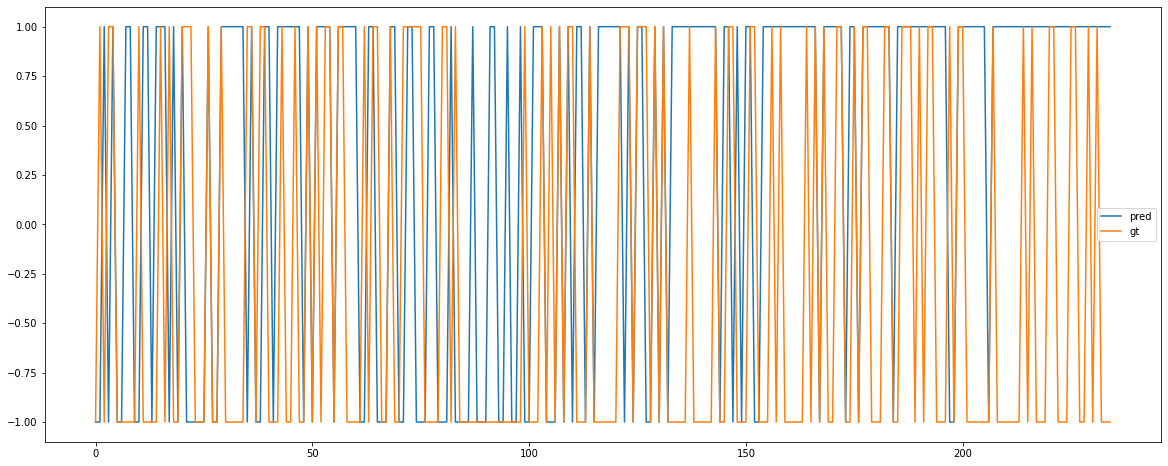

0.4808510638297872
[[1.         0.06532088]
 [0.06532088 1.        ]]


In [20]:
# X_test, y_test = X_val, y_val
best_svc = SVC(**best_params_acc)
best_svc.fit(X_train, y_train.squeeze())
preds = best_svc.predict(X_test)
plt.plot(preds)
plt.plot(y_test.squeeze())
plt.legend(["pred","gt"])
plt.show()
print(accuracy_score(y_test.squeeze(), preds))
print(np.corrcoef(preds, y_test))


In [38]:
from lightgbm import LGBMClassifier
params = {'lambda_l1': 1.9390010670101473e-08,
#  'lambda_l2': 0.6202550349656709e-8,
 'num_leaves': 100,
 'feature_fraction': 0.567803830762309,
 'bagging_fraction': 0.5281015648602314,
#  'bagging_freq': 9,
 'min_child_samples': 82}
model = LGBMClassifier(**params)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(accuracy_score(y_test.squeeze(), preds))
print(np.corrcoef(preds.squeeze(), y_test.squeeze())[0][1])

[LightGBM] [Warning] bagging_fraction is set=0.5281015648602314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5281015648602314
[LightGBM] [Warning] feature_fraction is set=0.567803830762309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.567803830762309
[LightGBM] [Warning] lambda_l1 is set=1.9390010670101473e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9390010670101473e-08
0.4978723404255319
-0.007970049709711737


/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
type(y_test)

numpy.ndarray

In [43]:
from lightgbm import LGBMClassifier, LGBMRegressor

classifier = LGBMClassifier()

classifier.fit(X_train, y_train)
preds = classifier.predict(X_val)

y_test = y_test.squeeze()
y_val = y_val.squeeze()

print(np.corrcoef(preds, y_val))

print(accuracy_score(preds, y_val))

[[1.         0.04687127]
 [0.04687127 1.        ]]
0.5299145299145299


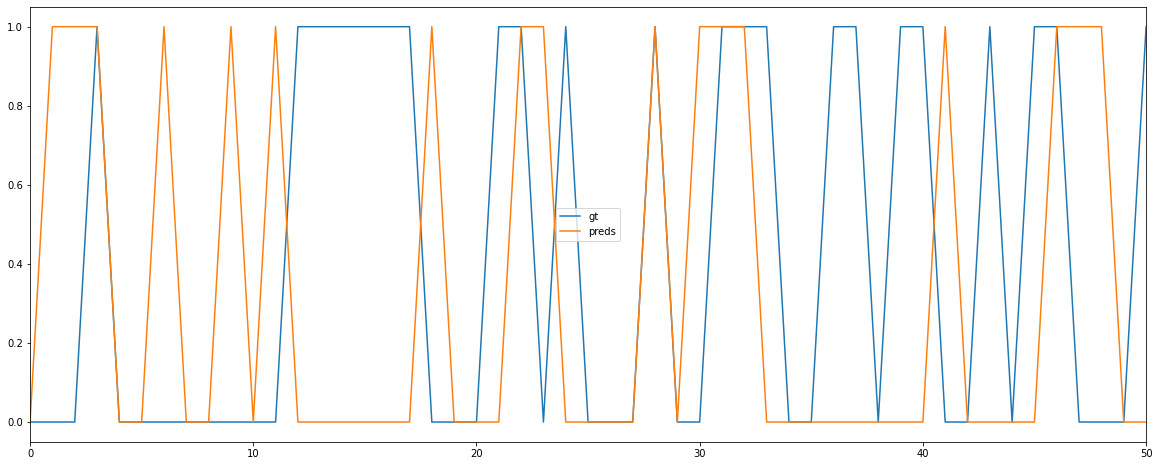

In [74]:
# plt.figure(figsize=(20, 8))
plt.xlim(0, 50)
plt.plot(y_val)
plt.plot(preds)
plt.legend(["gt", "preds"])
plt.show()

# array([[1.        , 0.43383203],
#        [0.43383203, 1.        ]])

In [62]:
import optuna
from optuna.integration import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import warnings 
warnings.filterwarnings("ignore")


lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val)

def objective(trial):
    params = {
        'objective': 'cross_entropy',
        'metric': 'auc',
        'boosting': 'gbdt',
        'learning_rate': 0.05,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'seed': 0,
        'verbosity': -1,
    }

    gbm = lgb.train(params, lgb_train, valid_sets=lgb_val,\
                                verbose_eval=False, num_boost_round=1000, early_stopping_rounds=100)
            
    preds = gbm.predict(X_val)

    # score = np.corrcoef(preds, y_val)[0][1]
    score = accuracy_score(y_val, preds)
    # score = roc_auc_score(preds, y_val.squeeze())
    print("SCORE :>>",score)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)


[I 2022-02-01 15:30:50,666] A new study created in memory with name: no-name-d1961a4d-9fc1-434e-be1e-068bdaf9030e
[I 2022-02-01 15:30:50,669] A new study created in memory with name: no-name-27320e7e-776e-4623-abae-9f591658f4ed


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2022-02-01 15:30:50,896] Trial 0 finished with value: 0.5381780660377359 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.5381780660377359.
[I 2022-02-01 15:30:51,024] Trial 1 finished with value: 0.5391935272536688 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.5391935272536688.
[I 2022-02-01 15:30:51,208] Trial 2 finished with value: 0.5433372641509434 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.5433372641509434.
[I 2022-02-01 15:30:51,591] Trial 3 finished with value: 0.5340998427672956 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.5433372641509434.
[I 2022-02-01 15:30:51,797] Trial 4 finished with value: 0.5477266771488469 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 0.5477266771488469.
[I 2022-02-01 15:30:51,994] Trial 5 finished with value: 0.5433372641509434 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 0.5477266771488469

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [18]:
# {'lambda_l1': 1.9390010670101473e-08,
#  'lambda_l2': 0.6202550349656709,
#  'num_leaves': 455,
#  'feature_fraction': 0.567803830762309,
#  'bagging_fraction': 0.5281015648602314,
#  'bagging_freq': 9,
#  'min_child_samples': 82}

# {'lambda_l1': 0.9248991074767056,
#  'lambda_l2': 0.09106360034019644,
#  'num_leaves': 397,
#  'feature_fraction': 0.8077323166572944,
#  'bagging_fraction': 0.6156679245716032,
#  'bagging_freq': 2,
#  'min_child_samples': 36}

# {'feature_fraction':0.4,
# 'num_leaves': 133,
# 'bagging_fraction':0.4008518884794043,
# 'feature_fraction': 0.41600000000000004,
# 'lambda_l1': 0.001470434265854021, 
# 'lambda_l2': 8.574068818296145e-08,
# 'min_child_samples':100}

{'lambda_l1': 1.9390010670101473e-08,
 'lambda_l2': 0.6202550349656709,
 'num_leaves': 455,
 'feature_fraction': 0.567803830762309,
 'bagging_fraction': 0.5281015648602314,
 'bagging_freq': 9,
 'min_child_samples': 82}

In [65]:
params = {'feature_fraction':0.4,
'num_leaves': 133,
'bagging_fraction':0.4008518884794043,
'feature_fraction': 0.41600000000000004,
'lambda_l1': 0.001470434265854021, 
'lambda_l2': 8.574068818296145e-08,
'min_child_samples':100}
model = LGBMClassifier(**params)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f"corr:{np.corrcoef(y_test, preds)[0][1]}, acc:{accuracy_score(y_test, preds)}")

[LightGBM] [Warning] bagging_fraction is set=0.4008518884794043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4008518884794043
[LightGBM] [Warning] feature_fraction is set=0.41600000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41600000000000004
[LightGBM] [Warning] lambda_l2 is set=8.574068818296145e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.574068818296145e-08
[LightGBM] [Warning] lambda_l1 is set=0.001470434265854021, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001470434265854021
corr:0.01852824908078906, acc:0.5276595744680851


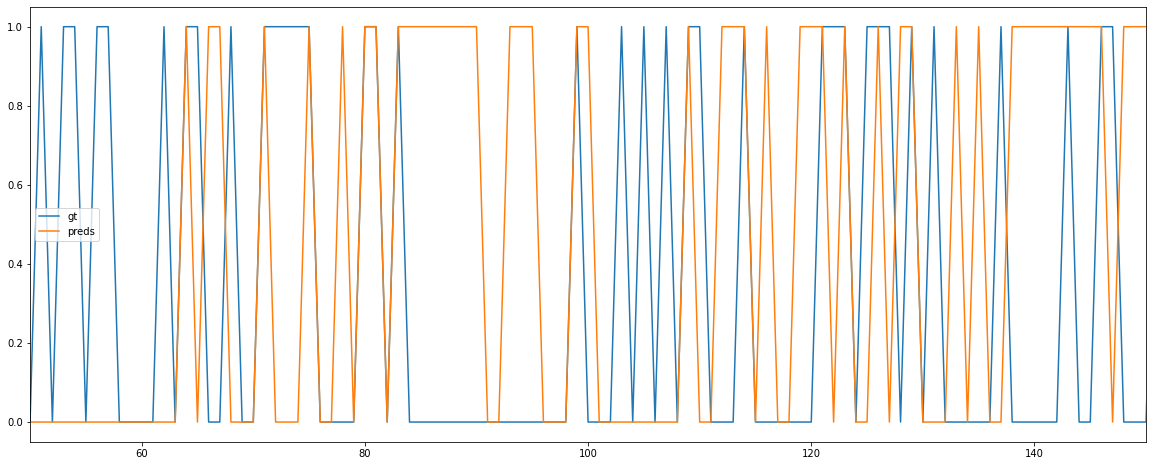

In [68]:
plt.xlim(50, 150)
plt.plot(y_test)
plt.plot(preds)
plt.legend(["gt", "preds"])


In [41]:

2*pd.Series(X_train[:, 2]).describe().T["std"] + pd.Series(X_train[:, 2]).describe().T["mean"]

0.35260090622252604

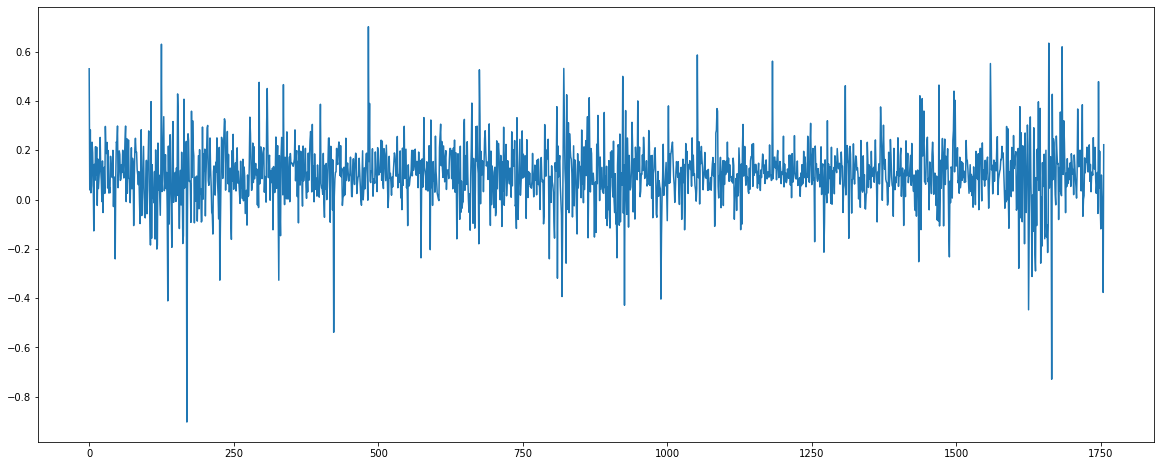

In [40]:
plt.plot(X_train[:, 2])

In [55]:
# scaler = MinMaxScaler((-1, 1))
pd.Series(X_train[:, 2]).describe().T["mean"], pd.Series(X_train[:, 2]).describe().T["std"]/2

(0.10240869663496897, 0.06254805239688926)